# Session 4 Explication post-hoc de modèles "boîte noire"

Dans ce notebook, nous allons nous intéresser à des modèles type "Réseaux de neurones" et utiliser quelques outils pour les interpréter post-hoc.

## Prérequis

En plus des modules que nous avons déjà installé, vous aurez besoin des modules suivants: keras, tensorflow.

Notez que tensorflow ne fonctionne pas avec python 3.9. Cependant, vous pouvez installer une version non-stable avec tf-nightly.

## Chargement d'un modèle pré-entraîné

Nous allons utiliser Keras et le modèle [inception v3](http://arxiv.org/abs/1512.00567). Il s'agit d'un CNN spécialisé dans la reconnaissance d'objets. Nous vous donnons également une petite fonction qui permet de mettre au bon format une image.

In [1]:
import tensorflow
from tensorflow.keras.applications import inception_v3
from keras import preprocessing
import keras.applications
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

model = inception_v3.InceptionV3()

def preprocess_img_list(liste):
    """Prend une liste de chaines de caractères représentant les paths des images à charger 
       et retourne une collection d'objets utilisables par le CNN"""
    out = []
    for img_path in liste:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inception_v3.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

def show(img):
    """Affiche une image prétraitée"""
    plt.imshow(img / 2 + 0.5)

96116736/96112376 [==============================] - 80s 1us/step


## Prise en main du modèle

Affichez la description de `model`en appelant sa méthode `summary`.

In [2]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

Pré-traitez l'image `image1.jpg` et affichez-la avec les méthodes `preprocess_img_list` et `show` déclarées ci-dessus. 
Ensuite, utilisez la méthode `predict` de `model` en lui donnant le résultat de `preprocess_img_list` et stockez les prédictions dans une variable (`preds` par exemple).

En utlisant `decode_predictions(preds)`, vous obtiendez une énumération des classes pour chacune des images que vous pouvez parcourir avec un `for`. Affichez les prédictions pour cette image.

('n02437312', 'Arabian_camel', 0.95046294)
('n02437616', 'llama', 0.0014278571)
('n02917067', 'bullet_train', 0.0010896128)
('n04243546', 'slot', 0.0004430996)
('n04067472', 'reel', 0.00038129004)


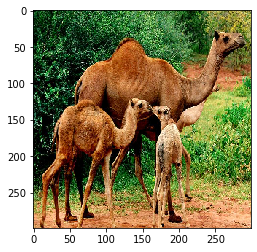

In [12]:
images = preprocess_img_list(['image1.jpg'])

#affichez l'image ici
show(images[0])

#obtenez la prédiction ici
preds = model.predict(images)

#affichez les prédictions ici
decodings = decode_predictions(preds)[0]
for decoding in decodings:
    print(decoding)


# LIME

Dans cette partie, nous allons appliquer LIME à cette image. LIME va nous donner pour chacune des classes les pixels qui ont conduit à cette décision.

## Obtention de l'explication
Créez un `LimeImageExplainer`.
Utilisez sa méthode `explain_instance` pour obtenir l'explication. Cette méthode prend pour arguments:
* l'image, qu'il faut convertir en tableau de double avec `images[0].astype('double')`
* la méthode `predict` de `model`

Il faudra ensuite fournir les paramètres optionnels suivants:
* `top_labels`: indique combien de classes il faut considérer
* `hide_color`: couleur utilisée pour les pixels qui ne font pas partie de l'explication. Mettez 0 (gris) 
* `num_samples`: combien d'échantillons vont être générés par LIME. Attention, comme il s'agit d'images, ça va être long...

In [14]:
%load_ext autoreload
%autoreload 2
import lime
from lime import lime_image


In [15]:
lime_explainer = lime_image.LimeImageExplainer()
exp = lime_explainer.explain_instance(images[0].astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=100)

## Affichage de l'explication

A présent, vous avez l'explication et il faut l'afficher. Pour cela, utilisez la méthode `get_image_and_mask` de `explanation` qui prend en argument obligatoire:
* la classe concernée: typiquement, on lui passe `explanation.top_labels[i]` où i est la ième top classe.

Puis, en argument optionnel:
* `positive_only`: un booléen qui indique si l'on veut afficher uniquement les pixels qui expliquent positivement la classe. En général, on met True
* `num_features`: indique le nombre de superpixels qui s'afficheront
* `hide_rest`: booléen qui indique que la partie non explicative de l'image soit grisée. Générallement, False.

Cette fonction retourne deux résultats: un résultat intermédiaire et un masque.
On vous donne une fonction qui affiche l'image résultat et qui prend `temp`et `mask` en paramètres.

In [29]:
from skimage.segmentation import mark_boundaries

def show(temps, mask):
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))



Explication de: Arabian_camel


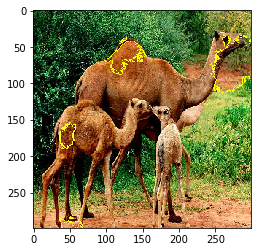

In [30]:
#obtenez le masque ici
label_i = 0
temp, mask = exp.get_image_and_mask(exp.top_labels[label_i], positive_only=True, num_features=5, hide_rest=False)
print("Explication de:", decodings[label_i][1])
show(temp, mask)

Explication de: llama


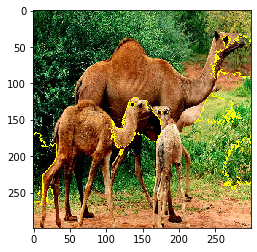

In [28]:
label_i = 1
temp, mask = exp.get_image_and_mask(exp.top_labels[label_i], positive_only=True, num_features=5, hide_rest=False)
print("Explication de:", decodings[label_i][1])
show(temp, mask)

Explication de: bullet_train


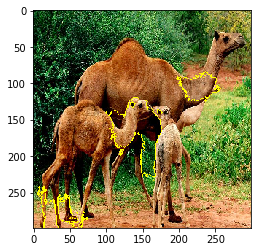

In [24]:
label_i = 2
temp, mask = exp.get_image_and_mask(exp.top_labels[label_i], positive_only=True, num_features=5, hide_rest=False)
print("Explication de:", decodings[label_i][1])
show(temp, mask)

Explication de: slot


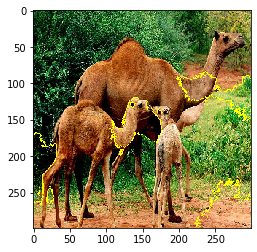

In [25]:
label_i = 3
temp, mask = exp.get_image_and_mask(exp.top_labels[label_i], positive_only=True, num_features=5, hide_rest=False)
print("Explication de:", decodings[label_i][1])
show(temp, mask)

Explication de: reel


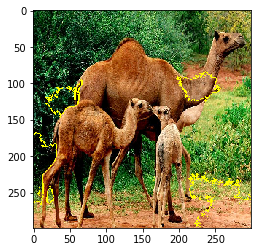

In [26]:
label_i = 4
temp, mask = exp.get_image_and_mask(exp.top_labels[label_i], positive_only=True, num_features=5, hide_rest=False)
print("Explication de:", decodings[label_i][1])
show(temp, mask)

## Interprétation

Testez sur les différentes classes détectées. Interprétez les résultats.

In [31]:
#Interprétez ici dans une string 
"""
La bosse du camel est l'élément le plus explicatif de la classe arabian camel.
On voit aussi que le background et une toute petite partie du coup ainsi que qu'une petite ozone autour de la jambe du petit camel sont utilisés pour expliquer cette classe, 
On sait que ce ne sont pas les élements les plus pertinents pour decrire cette classe. Des feautures comme les longues jambes ou le long coup d'un camel aurait été plus descriptive,
cependant on ne peut pas dire qu'il s'agit de la faute de lime car tout dépend de ce qu'a appris le modele.
"""

"\nLa bosse du camel est l'élément le plus explicatif de la classe arabian camel.\nOn voit aussi que le background et une toute petite partie du coup ainsi que qu'une petite ozone autour de la jambe du petit camel sont utilisés pour expliquer cette classe, \nOn sait que ce ne sont pas les élements les plus pertinents pour decrire cette classe. Des feautures comme les longues jambes ou le long coup d'un camel aurait été plus descriptive,\ncependant on ne peut pas dire qu'il s'agit de la faute de lime car tout dépend de ce qu'a appris le modele.\n"

## Autre image

Utilisez à présent l'image 2. Interprétez le résultat.

('n02108422', 'bull_mastiff', 0.13167733)
('n02108915', 'French_bulldog', 0.107900105)
('n02395406', 'hog', 0.04833029)
('n02108089', 'boxer', 0.044218138)
('n02927161', 'butcher_shop', 0.03928927)


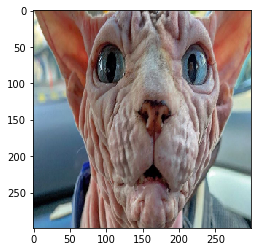

In [35]:

def show(img):
    """Affiche une image prétraitée"""
    plt.imshow(img / 2 + 0.5)

images = preprocess_img_list(['image2.jpg'])

#affichez l'image ici
show(images[0])

#obtenez la prédiction ici
preds = model.predict(images)

#affichez les prédictions ici
decodings = decode_predictions(preds)[0]
for decoding in decodings:
    print(decoding)

In [36]:
exp = lime_explainer.explain_instance(images[0].astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=100)

In [37]:
def show(temps, mask):
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Explication de: bull_mastiff


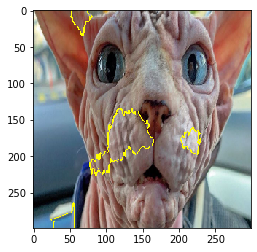

In [44]:
label_i = 0
temp, mask = exp.get_image_and_mask(exp.top_labels[label_i], positive_only=True, num_features=5, hide_rest=False)
print("Explication de:", decodings[label_i][1])
show(temp, mask)

Explication de: French_bulldog


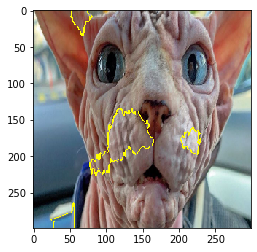

In [45]:
label_i = 1
temp, mask = exp.get_image_and_mask(exp.top_labels[label_i], positive_only=True, num_features=5, hide_rest=False)
print("Explication de:", decodings[label_i][1])
show(temp, mask)

Explication de: hog


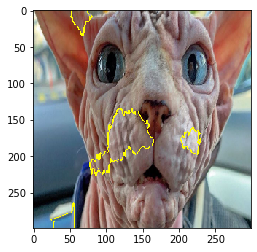

In [51]:
label_i = 2
temp, mask = exp.get_image_and_mask(exp.top_labels[label_i], positive_only=True, num_features=5, hide_rest=False)
print("Explication de:", decodings[label_i][1])
show(temp, mask)

In [52]:
""" 
On constate que les deux classes ayant plus de probabilités sont des chiens.
La zone pres du nez à gauche est constitué de rides assez marqué ce qui est caracteristique des chiens tels que les bull dogs.
Lime arrive à expliquer cela. Ensuite, il y a une petite zone pres de l 'oreill sur la partie gauche de l'image, qui est caracteristique des chiens.
On remarque que les zones decrites par lime sont quasiment les memes pour les trois labels les plus probables. 
Etant donné que ces trois labels sont des types de chiens, lime arrive à en tout cas localement expliquer le modele assez bien.
"""

" \nOn constate que les deux classes ayant plus de probabilités sont des chiens.\nLa zone pres du nez à gauche est constitué de rides assez marqué ce qui est caracteristique des chiens tels que les bull dogs.\nLime arrive à expliquer cela. Ensuite, il y a une petite zone pres de l 'oreill sur la partie gauche de l'image, qui est caracteristique des chiens.\nOn remarque que les zones decrites par lime sont quasiment les memes pour les trois labels les plus probables. \nEtant donné que ces trois labels sont des types de chiens, lime arrive à en tout cas localement expliquer le modele assez bien.\n"